# k-Nearest Neighbor


This function illustrates how to use k-nearest neighbors in tensorflow

We will use the 1970s Boston housing dataset which is available through the UCI ML data repository. 

### Data:
----------x-values-----------
* CRIM   : per capita crime rate by town
* ZN     : prop. of res. land zones
* INDUS  : prop. of non-retail business acres
* CHAS   : Charles river dummy variable
* NOX    : nitrix oxides concentration / 10 M
* RM     : Avg. # of rooms per building
* AGE    : prop. of buildings built prior to 1940
* DIS    : Weighted distances to employment centers
* RAD    : Index of radian highway access
* TAX    : Full tax rate value per $10k
* PTRATIO: Pupil/Teacher ratio by town
* B      : 1000*(Bk-0.63)^2, Bk=prop. of blacks
* LSTAT  : % lower status of pop

------------y-value-----------
* MEDV   : Median Value of homes in $1,000's

In [1]:
# import required libraries
#importing pyplot from matplotlib for visualization
import matplotlib.pyplot as plt
#importing numpy
import numpy as np
#importing tensorflow
import tensorflow as tf
#importing requests which will be used for fetching data
import requests
#Clearing the default graph stack and resetting the global default graph.
from tensorflow.python.framework import ops
ops.reset_default_graph()
#importing debug library
from tensorflow.python import debug as tf_debug

### Create graph

In [2]:
#creating a session object which creates an environment where we can execute Operations and evaluate Tensors
sess = tf.Session()

## Debugger

### Uncomment the below line and execute the code to run the debugger.

### Go to the link once you start execution    			http://localhost:6006/ (Sometimes, this might not work. Once verify the terminal to check the correct URL to access Tensorboard).

In [3]:
#Uncomment the below line to run the debugger
#sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")

#For debugging on CLI ---> Uncomment the below line. Run only as a .py(executable) file

#sess = tf_debug.LocalCLIDebugWrapperSession(sess)

### Load the data

In [4]:
#URL for the boston housing data in UCI repository is set to the variable
housing_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
#the different features in the dataset
housing_header = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
#the features being used in our model
cols_used = ['CRIM', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
#The number of features being used in the model
num_features = len(cols_used)
#Using requests, load the url containing the dataset and fetch the data
housing_file = requests.get(housing_url)
#For each line withe length greater than 0, split the line based on space and store it in a 2-d list
housing_data = [[float(x) for x in y.split(' ') if len(x)>=1] for y in housing_file.text.split('\n') if len(y)>=1]

#retrieve the 13th value in each row of the 2-d list, convert it to a numpy array, take transpose to obtain n x 1 array
y_vals = np.transpose([np.array([y[13] for y in housing_data])])
#retrieve the data belonging to the features to be used in the model, convert it to a 2-d numpy array
x_vals = np.array([[x for i,x in enumerate(y) if housing_header[i] in cols_used] for y in housing_data])

## Min-Max Scaling
#Normalize the data
x_vals = (x_vals - x_vals.min(0)) / x_vals.ptp(0)

### Split the data into train and test sets

In [5]:
#Seeding a pseudo-random number generator to give it its first previous value, making future generations reproducible
np.random.seed(13)  #make results reproducible
#generate a random list of indices having 80% of the original indices, use it to form the train data
train_indices = np.random.choice(len(x_vals), int(round(len(x_vals)*0.8)), replace=False)
#use the indices generated in the previous step and retrieve the remaining 20% of the indices for test data
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
#using the list of indices genereated obtain the training data from x_vals
x_vals_train = x_vals[train_indices]
#using the list of test indices generated obtain the testing data from x_vals
x_vals_test = x_vals[test_indices]
#use the same set of train indices and obtain the corresponding labels for the train data
y_vals_train = y_vals[train_indices]
#use the same set of test indices and obtain the corresponding lables for the test data
y_vals_test = y_vals[test_indices]

### Parameters to control run

In [6]:
# Declare k-value and batch size
#Setting the k value, used in the calulation of nearest neighbors
k = 4
#set the batch size to length of test data, number of training samples to be used in one iteration
batch_size=len(x_vals_test)

# Placeholders
#Inserting a placeholder for a tensor of size train data
x_data_train = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
#Inserting a placeholder for a tensor of size test data
x_data_test = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
#Inserting a placeholder for a tensor of labels size of train data
y_target_train = tf.placeholder(shape=[None, 1], dtype=tf.float32)
#Inserting a placeholder for a tensor of labels size of test data
y_target_test = tf.placeholder(shape=[None, 1], dtype=tf.float32)

## Declare distance metric

### L1 Distance Metric

Uncomment following line and comment L2

In [7]:
#the following line calculates the distance matrix using manhattan distance metric
#the distance is calulated between each test point and all train data points
distance = tf.reduce_sum(tf.abs(tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))), axis=2)

### L2 Distance Metric

Uncomment following line and comment L1 above

In [8]:
#the following line calculates the distance matrix using eucledian distance metric
#the distance is calulated between each test point and all train data points
#distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(x_data_train, tf.expand_dims(x_data_test,1))), reduction_indices=1))

## Predict: Get min distance index (Nearest neighbor)

In [9]:
#prediction = tf.arg_min(distance, 0)
#Finds values and indices of the k largest entries for the negative values of distance matrix (smallest positive)
top_k_xvals, top_k_indices = tf.nn.top_k(tf.negative(distance), k=k)
#reduce the tensor to a 1-d tensor (flatten) and add the second dimension
x_sums = tf.expand_dims(tf.reduce_sum(top_k_xvals, 1),1)
#creating a matrix of 1's of size 1xk and multiplying it with the sum matrix generated in previous steps
x_sums_repeated = tf.matmul(x_sums,tf.ones([1, k], tf.float32))
#dividing each value in top_k_val matrix with correspoding value from x_sums repeated and expanding its dimension by 1
x_val_weights = tf.expand_dims(tf.div(top_k_xvals,x_sums_repeated), 1)


#retrieve the labels belonging to the top_k_indices
top_k_yvals = tf.gather(y_target_train, top_k_indices)

#multiply the caluclated weights with the respective labels and reduce the dimension of tensor by 1
prediction = tf.squeeze(tf.matmul(x_val_weights,top_k_yvals), axis=[1])
#prediction = tf.reduce_mean(top_k_yvals, 1)


# Calculate MSE
#calculating mean square error for the predicted labels and divide it by the batch size
mse = tf.div(tf.reduce_sum(tf.square(tf.subtract(prediction, y_target_test))), batch_size)


# Calculate how many loops over training data
num_loops = int(np.ceil(len(x_vals_test)/batch_size))

#iterating for the training data for num_loops
for i in range(num_loops):
    #starting index of the current batch
    min_index = i*batch_size
    #ending index of the current batch
    max_index = min((i+1)*batch_size,len(x_vals_train))
    #data for testing of batch size
    x_batch = x_vals_test[min_index:max_index]
    #labels for the test data of batch size
    y_batch = y_vals_test[min_index:max_index]
    #run the graph fragment to execute the operation (predcition) and evaluate each tensor using data from feed_dict
    predictions = sess.run(prediction, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})
    #run the graph fragment to execute the operation (calculate mse) and evaluate each tensor using data from feed_dict
    batch_mse = sess.run(mse, feed_dict={x_data_train: x_vals_train, x_data_test: x_batch,
                                         y_target_train: y_vals_train, y_target_test: y_batch})

    #print the mse for the current batch
    print('Batch #' + str(i+1) + ' MSE: ' + str(np.round(batch_mse,3)))

9 ops no flops stats due to incomplete shapes.


Batch #1 MSE: 14.38


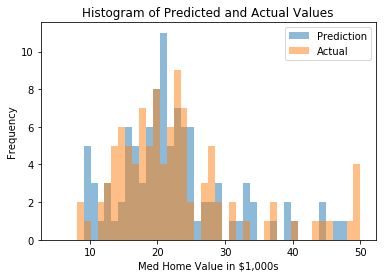

In [10]:
#the output of plotting commands is displayed inline within frontends, stored in notebook
%matplotlib inline
# Plot prediction and actual distribution
#store 45 evenly spaced numbers between 5 and 50
bins = np.linspace(5, 50, 45)

#plot the histogram for predicted values
plt.hist(predictions, bins, alpha=0.5, label='Prediction')
#plot the histogram for actual values
plt.hist(y_batch, bins, alpha=0.5, label='Actual')
#set title for the histogram
plt.title('Histogram of Predicted and Actual Values')
#labeling the x-axis of the plot
plt.xlabel('Med Home Value in $1,000s')
#labeling the y-axis of the plot
plt.ylabel('Frequency')
#set the location of the legend on the plot
plt.legend(loc='upper right')
#display the plot
plt.show()